Assumptions:


*   it's October 2022; this point in time has been chosen because EURIBOR value of 1.4277% which occured then is the closest within the last one and a half year 3-months EURIBOR to the 1.5% indicated in the exercise.
*   Chipa wants to start the financing in January 2023. 31st of Jan is going to be the effective day of the financing product company chooses.
*   Company needs to borrow $1 000 000 .







In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
effective_date = datetime(2023, 1, 31, 0, 0, 0, 0)

In [3]:
def compute_Total_Cost(
        rates: list,
        date_Of_Start: datetime,
        fixedComponent,
        principal=1000000):

    curr_timestamp = date_Of_Start
    total_payment = 0

    for rate in rates:

        prev_timestamp = curr_timestamp
        curr_timestamp = prev_timestamp + relativedelta(months=+3)


        d = (curr_timestamp - prev_timestamp).days

        total_payment += principal * (rate + fixedComponent) * d / 360

    return total_payment

##LOAN COST

In [4]:
int_rate = 0.0596
int_rate_list = [int_rate] * 40
compute_Total_Cost(int_rate_list, effective_date, 0)

604608.888888889

## PREDICTING EURIBOR RATES IN THE NEXT 10 YEARS

ARIMA implemented based on https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Source of EURIBOR data: https://data.ecb.europa.eu/data/datasets/FM/FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA

In [5]:
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

            EURIBOR VALUE
DATE                     
2022-06-30        -0.2392
2022-07-31         0.0366
2022-08-31         0.3947
2022-09-30         1.0109
2022-10-31         1.4277


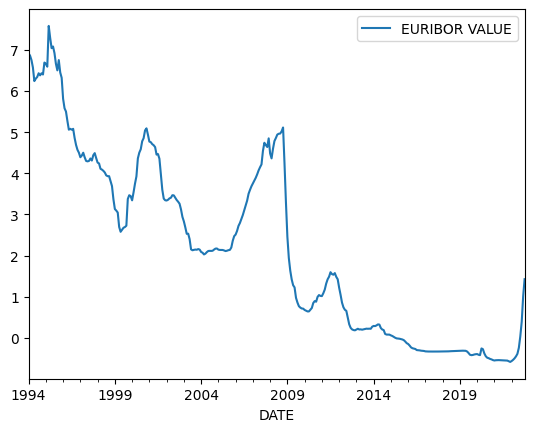

In [6]:
df = pd.read_csv('ECB Data Portal_20231010202759.csv', header=0, parse_dates=[0], index_col=0)
df = df.drop('TIME PERIOD', axis=1).rename({'Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)': 'EURIBOR VALUE'}, axis=1).iloc[0:346,]
print(df.tail())
df.plot()
pyplot.show()

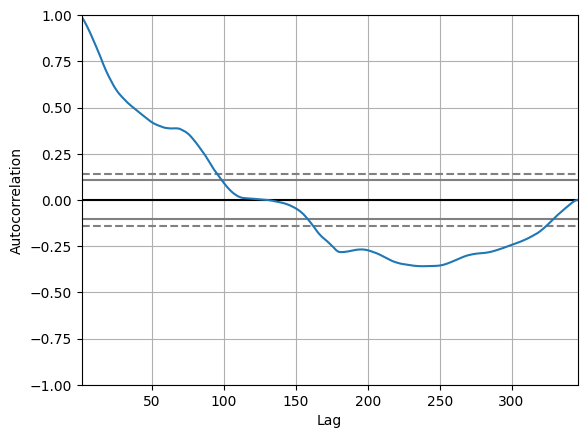

In [7]:
autocorrelation_plot(df)
pyplot.show()

In [8]:
#40 quarters x 3 months of each quarter
periodOfFinancing = 40*3

In [9]:
df

,EURIBOR VALUE
DATE,
1994-01-31,6.9100
1994-02-28,6.8600
1994-03-31,6.7500
1994-04-30,6.5700
1994-05-31,6.2400
...,...
2022-06-30,-0.2392
2022-07-31,0.0366
2022-08-31,0.3947


In [10]:
df.index = df.index.to_period('M')

In [11]:
#df.index = df.index.to_period('M')
model = ARIMA(df, order=(100, 1, 0))
model_fit = model.fit()
predictions = model_fit.get_forecast(periodOfFinancing)
predictions

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# model_fit.summary()

In [13]:
predictions = predictions.predicted_mean.to_list()

In [14]:
# predictions

In [15]:
#It's quarterly so we take every third predicted value:
def every_nth(nums, nth):
  return nums[nth - 1::nth]

In [16]:
predictedQuatEURIBOR = every_nth(predictions, 3)
len(predictedQuatEURIBOR)

40

In [17]:
# The number to which all the elements of the list will be divided
divisor = 100

# Performing list comprehension and saving the
# result in a separate variable
predictedQuatEURIBOR = [x/divisor for x in predictedQuatEURIBOR]

Rounded to 4 because EURIBOR is published in this form

In [18]:
predictedQuatEURIBORrounded = [ round(elem, 4) for elem in predictedQuatEURIBOR ]

Predicted values + 40%

In [19]:
predictedRoundedPlus = [ round(elem + elem*0.4, 4) for elem in predictedQuatEURIBORrounded ]
predictedRoundedPlus

Predicted values - 40 %

In [20]:
predictedRoundedMinus = [ round(elem - elem*0.4, 4) for elem in predictedQuatEURIBORrounded ]
# predictedRoundedMinus

In [38]:
import numpy as np
def avgEur(predlist):

  avgEuribor = sum(predlist)/len(predlist)

  euriborArray = np.array(predlist)
  medEuribor = np.median(euriborArray)

  print(avgEuribor, medEuribor)

In [39]:
avgEur(predictedQuatEURIBORrounded)
avgEur(predictedRoundedPlus)
avgEur(predictedRoundedMinus)

0.023372499999999994 0.0239
0.0327225 0.0335
0.014022499999999997 0.0143


In [23]:
import numpy as np
euriborArray = np.array(predictedQuatEURIBORrounded)
np.median(euriborArray)

0.0239

##EURIBOR-based alternatives

FRN and IRS  https://shamit8.files.wordpress.com/2014/11/fixed-income-securities-bruce-tuckman2002-2ndedition.pdf p.374

act/360 https://books.vipeople.com/assets/bdata/book/70177b6505642d6c863f0e70b0dff85c.pdf p.32

In [24]:
def compute_CAP_FLOOR_cashflows(
        rates: list,
        date_Of_Start: datetime,
        strike,
        optionType,
        perc_premium,
        notional=1000000):

    curr_timestamp = date_Of_Start
    total_settlement = 0

    for rate in rates:

        prev_timestamp = curr_timestamp
        curr_timestamp = prev_timestamp + relativedelta(months=+3)


        d = (curr_timestamp - prev_timestamp).days

        if optionType == "cap":
          total_settlement += ((max(rate - strike, 0) * d)/360) * notional
        else:
          total_settlement += ((max(strike - rate, 0) * d)/360) * notional


        # premium calculation
        premium = perc_premium * notional * len(rates)


    return (total_settlement, premium)

In [25]:
def presentResults(predictedList, sufix):

  var_names_list = ['LOAN_total_cost',
                    'FRN_Coupons_Cost',
                    'IRS_Floating_Leg', 'IRS_Fixed_Leg', 'FRN_Total_Spread_Cost', 'Cost_FRN_AND_IRS_Total',
                    'CAPsettlements_Total', 'CAP_premium_Total',
                    'FLOORsettlements_total', 'FLOOR_premium_Total',
                    'COLLAR_NET',
                    'FRN_CAP_NET', 'FRN_FLOOR_NET',
                    'FRN_COLLAR_NET' ]

  suf_res = [sub + sufix for sub in var_names_list]

  effective_date = datetime(2023, 1, 31, 0, 0, 0, 0)
  num_quarters = 40

  #LOAN
  int_rate = 0.0596
  int_rate_list = [int_rate] * num_quarters
  globals()[f'{suf_res[0]}'] =  round(compute_Total_Cost(int_rate_list, effective_date, 0), 2)
  print(f"LOAN: Total loan cost after {num_quarters} quarters is {globals()[f'{suf_res[0]}']}.")



  #FRN coupons
  spread = 0.0285 #depends on credit rating
  print(f"Predicted EURIBOR rates are {predictedList}")
  globals()[f'{suf_res[1]}'] = round(compute_Total_Cost(predictedList, effective_date, spread), 2)
  print(f"FRN: Total coupons value after {num_quarters} coupon payments (quarters) is {globals()[f'{suf_res[1]}']}.")


  #IRS floating rate leg
  date_Of_Start_IRS = effective_date + relativedelta(days=+2)
  globals()[f'{suf_res[2]}'] = round(compute_Total_Cost(predictedList, date_Of_Start_IRS, 0), 2)
  print(f"IRS: Total floating leg cashflows value after {num_quarters} quarters is {globals()[f'{suf_res[2]}'] }.")


  #IRS fixed leg
  # list with 40xthe same rate
  fixedRate = 0.0299
  IRS_Fixed_Leg_List = [fixedRate] * num_quarters
  globals()[f'{suf_res[3]}'] = round(compute_Total_Cost(IRS_Fixed_Leg_List, date_Of_Start_IRS, 0), 2)
  print(f"IRS: Total fixed leg cashflows value after {num_quarters} payments is {globals()[f'{suf_res[3]}']}.")


  # FRN based on fixed +$2.85
  # list with 40xthe same rate
  FRN_Fixed_Component_list = [spread] * num_quarters
  globals()[f'{suf_res[4]}'] = compute_Total_Cost(FRN_Fixed_Component_list, effective_date, 0)
  print(f"FRN Fixed part: Total spread cost within FRN coupons after {num_quarters} is { globals()[f'{suf_res[4]}'] }.")


  #Total fixed cost of FRN & IRS
  globals()[f'{suf_res[5]}'] = round( globals()[f'{suf_res[1]}'] + globals()[f'{suf_res[3]}'] - globals()[f'{suf_res[2]}'], 2)
  print(f" Total cost of FRN combined with IRS: { globals()[f'{suf_res[5]}']  }.")


  #CAP settlements
  optionType = "cap"
  strikeCap = 0.0355
  premiumRateCap = 0.0039
  globals()[f'{suf_res[6]}'] = round(compute_CAP_FLOOR_cashflows(predictedList, effective_date, strikeCap, optionType, premiumRateCap)[0], 2)
  print(f"CAP: Total CAP cashflows received after {num_quarters} are {globals()[f'{suf_res[6]}']}.")

  #CAP Premium
  globals()[f'{suf_res[7]}'] = round(compute_CAP_FLOOR_cashflows(predictedList, effective_date, strikeCap, optionType, premiumRateCap)[1], 2)
  print(f"CAP: Total CAP premium paid after {num_quarters} is {globals()[f'{suf_res[7]}']}.")



  #FLOOR
  optionType = "floor"
  strikeFloor = 0.015
  premiumRateFloor = 0.0037
  globals()[f'{suf_res[8]}'] = round(compute_CAP_FLOOR_cashflows(predictedList, effective_date, strikeFloor, optionType, premiumRateFloor)[0], 2)
  #print(f"FLOOR: Total FLOOR cashflows paid after {num_quarters} are {globals()[f'{suf_res[8]}']}.")

  #FLOOR Premium
  globals()[f'{suf_res[9]}'] = round(compute_CAP_FLOOR_cashflows(predictedList, effective_date, strikeFloor, optionType, premiumRateFloor)[1], 2)
  #print(f"FLOOR: Total FLOOR premium received after {num_quarters} is {globals()[f'{suf_res[9]}']}.")


  #COLLAR NET
  globals()[f'{suf_res[10]}'] = round((globals()[f'{suf_res[6]}'] + globals()[f'{suf_res[9]}']) - (globals()[f'{suf_res[7]}'] + globals()[f'{suf_res[8]}'] ) , 2)
  print(f"COLLAR NET: Net value of the collar after {num_quarters} is {globals()[f'{suf_res[10]}']}.")


  #FRN & CAP NET
  globals()[f'{suf_res[11]}'] = round(globals()[f'{suf_res[1]}'] + globals()[f'{suf_res[7]}'] - globals()[f'{suf_res[6]}'], 2)
  print(f"FRN & CAP NET: Cost of the FNR combined with the cap after {num_quarters} is {globals()[f'{suf_res[11]}']}.")


  #FRN & FLOOR NET
  globals()[f'{suf_res[12]}'] = round(globals()[f'{suf_res[1]}'] + globals()[f'{suf_res[8]}'] -  globals()[f'{suf_res[9]}'], 2)
  print(f"FRN & FLOOR NET: Cost of the FNR combined with the floor after {num_quarters} is {globals()[f'{suf_res[12]}']}.")

  #FRN & COLLAR NET
  globals()[f'{suf_res[13]}'] = round(globals()[f'{suf_res[1]}'] - globals()[f'{suf_res[10]}'] , 2)
  print(f"FRN & COLLAR NET: Cost of the FNR combined with the collar after {num_quarters} is {globals()[f'{suf_res[13]}']}.")

  countCap = 0
  for i in predictedList:
    if i > strikeCap:
      countCap = countCap + 1
  print("The numbers greater than strike for cap : " + str(countCap))

  countFloor = 0
  for i in predictedList:
    if i < strikeFloor:
      countFloor = countFloor + 1

  # printing the intersection
  print("The numbers lower than strike for floor : " + str(countFloor))

  return (globals()[f'{suf_res[0]}'],globals()[f'{suf_res[1]}'], globals()[f'{suf_res[2]}'],globals()[f'{suf_res[3]}'],globals()[f'{suf_res[4]}'],
          globals()[f'{suf_res[5]}'],globals()[f'{suf_res[6]}'], globals()[f'{suf_res[7]}'],globals()[f'{suf_res[8]}'],globals()[f'{suf_res[9]}'],
          globals()[f'{suf_res[10]}'],globals()[f'{suf_res[11]}'], globals()[f'{suf_res[12]}'],globals()[f'{suf_res[13]}'])

In [26]:
presentResults(predictedQuatEURIBOR, '_standard')

LOAN: Total loan cost after 40 quarters is 604608.89.
Predicted EURIBOR rates are [0.02116862678161272, 0.024462126141231107, 0.024992963557921175, 0.025007898982696394, 0.0239318052623013, 0.021070732945905016, 0.01963770335367184, 0.018960969042715634, 0.017761903093295246, 0.017632116764670785, 0.01763862893398707, 0.01841448293787948, 0.019397757357297766, 0.01916986116255152, 0.019404349042526425, 0.01841663032765537, 0.01696432352514806, 0.01686763103566628, 0.017132565780426254, 0.01764716910734808, 0.017799827707283333, 0.01986917931158816, 0.02215542305624035, 0.023873327356494934, 0.025771189770222577, 0.026065061630109437, 0.02556730450959095, 0.026451436227963806, 0.029639268029586698, 0.03163673145011116, 0.03242373804860087, 0.03348976640074596, 0.03240548889421123, 0.030668905527396685, 0.028698890338013053, 0.02774146430602807, 0.02693010716940579, 0.025982012092592953, 0.025780293393825114, 0.02613624615119299]
FRN: Total coupons value after 40 coupon payments (quarter

(604608.89,
 526197.2,
 237143.93,
 303401.94,
 289116.6666666667,
 592455.21,
 0.0,
 156000.0,
 0.0,
 148000.0,
 -8000.0,
 682197.2,
 378197.2,
 534197.2)

In [28]:
presentResults(predictedRoundedPlus, '_40Plus')

LOAN: Total loan cost after 40 quarters is 604608.89.
Predicted EURIBOR rates are [0.0297, 0.0343, 0.035, 0.035, 0.0335, 0.0295, 0.0274, 0.0266, 0.0249, 0.0246, 0.0246, 0.0258, 0.0272, 0.0269, 0.0272, 0.0258, 0.0238, 0.0237, 0.0239, 0.0246, 0.0249, 0.0279, 0.0311, 0.0335, 0.0361, 0.0365, 0.0358, 0.0371, 0.0414, 0.0442, 0.0454, 0.0469, 0.0454, 0.043, 0.0402, 0.0388, 0.0377, 0.0364, 0.0361, 0.0365]
FRN: Total coupons value after 40 coupon payments (quarters) is 621086.11.
IRS: Total floating leg cashflows value after 40 quarters is 332058.61.
IRS: Total fixed leg cashflows value after 40 payments is 303401.94.
FRN Fixed part: Total spread cost within FRN coupons after 40 is 289116.6666666667.
 Total cost of FRN combined with IRS: 592429.44.
CAP: Total CAP cashflows received after 40 are 17613.61.
CAP: Total CAP premium paid after 40 is 156000.0.
COLLAR NET: Net value of the collar after 40 is 9613.61.
FRN & CAP NET: Cost of the FNR combined with the cap after 40 is 759472.5.
FRN & FLOOR 

(604608.89,
 621086.11,
 332058.61,
 303401.94,
 289116.6666666667,
 592429.44,
 17613.61,
 156000.0,
 0.0,
 148000.0,
 9613.61,
 759472.5,
 473086.11,
 611472.5)

In [29]:
presentResults(predictedRoundedMinus, '_40Minus')

LOAN: Total loan cost after 40 quarters is 604608.89.
Predicted EURIBOR rates are [0.0127, 0.0147, 0.015, 0.015, 0.0143, 0.0127, 0.0118, 0.0114, 0.0107, 0.0106, 0.0106, 0.011, 0.0116, 0.0115, 0.0116, 0.011, 0.0102, 0.0101, 0.0103, 0.0106, 0.0107, 0.0119, 0.0133, 0.0143, 0.0155, 0.0157, 0.0154, 0.0159, 0.0178, 0.019, 0.0194, 0.0201, 0.0194, 0.0184, 0.0172, 0.0166, 0.0161, 0.0156, 0.0155, 0.0157]
FRN: Total coupons value after 40 coupon payments (quarters) is 431375.0.
IRS: Total floating leg cashflows value after 40 quarters is 142296.94.
IRS: Total fixed leg cashflows value after 40 payments is 303401.94.
FRN Fixed part: Total spread cost within FRN coupons after 40 is 289116.6666666667.
 Total cost of FRN combined with IRS: 592480.0.
CAP: Total CAP cashflows received after 40 are 0.0.
CAP: Total CAP premium paid after 40 is 156000.0.
COLLAR NET: Net value of the collar after 40 is -26348.33.
FRN & CAP NET: Cost of the FNR combined with the cap after 40 is 587375.0.
FRN & FLOOR NET: Co

(604608.89,
 431375.0,
 142296.94,
 303401.94,
 289116.6666666667,
 592480.0,
 0.0,
 156000.0,
 18348.33,
 148000.0,
 -26348.33,
 587375.0,
 301723.33,
 457723.33)

Max cost of FRN & CAP

In [34]:
effective_date = datetime(2023, 1, 31, 0, 0, 0, 0)
num_quarters = 40

int_rate = 0.0679
int_rate_list = [int_rate] * num_quarters
round(compute_Total_Cost(int_rate_list, effective_date, 0), 2) + round(0.0039 * 1000000 ,2)

692707.78

Max cost of FRN & collar

In [35]:
effective_date = datetime(2023, 1, 31, 0, 0, 0, 0)
num_quarters = 40

int_rate = 0.0642
int_rate_list = [int_rate] * num_quarters
round(compute_Total_Cost(int_rate_list, effective_date, 0), 2) + round(0.0039 * 1000000 ,2) - round(0.0037 * 1000000 ,2)

651473.33